In [1]:
from configparser import ConfigParser
import itertools as itt
import pathlib as pl

import joblib as jl
import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.optimize import minimize

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from IPython.display import Image

# from src.models.decoder import decoder
from src.data.tensor_loaders import tensor_loaders
from src.root_path import config_path
from src.utils.subsets import good_sites
from src.utils.tools import shuffle_along_axis
from src.metrics.time_series_summary import metrics_to_DF

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2023-02-09 192207.log


In [2]:
# Kinda baseline minimal parameterse
raster_meta = {'reliability': 0.1,  # r value
               'smoothing_window': 0,  # ms
               'raster_fs': 20,
               'zscore': True,
               'stim_type': 'permutations'}

probe = 3
ctx_pair = [0,1]
cellid = 'ARM021b-36-8'

site = cellid.split('-')[0]

In [3]:

# fn = load_site_formated_raster
# loads caches rasters and PCA raster. Caches SHOULD exists, as these are used for the cluster mass analysis.

rasters, channels = dict(), dict()
for source in ['SC', 'PCA']:
    fn = tensor_loaders[source]
    if fn.check_call_in_cache(site, **raster_meta):
        rasters[source], channels[source] = fn(site, **raster_meta)
        print(f'####\n'
              f'{source} raster shape {rasters[source].shape}'
              f'\n{channels[source]}')
    else:
        print(f"cant load {fn} with {raster_meta}.\n this should be cached, why is it failing? ")


####
SC raster shape (20, 33, 5, 4, 20)
['ARM021b-02-2', 'ARM021b-04-3', 'ARM021b-05-1', 'ARM021b-05-2', 'ARM021b-06-3', 'ARM021b-06-4', 'ARM021b-10-4', 'ARM021b-12-7', 'ARM021b-16-7', 'ARM021b-19-4', 'ARM021b-23-1', 'ARM021b-23-2', 'ARM021b-25-3', 'ARM021b-26-5', 'ARM021b-29-4', 'ARM021b-31-2', 'ARM021b-34-3', 'ARM021b-34-4', 'ARM021b-36-8', 'ARM021b-37-4', 'ARM021b-39-10', 'ARM021b-40-6', 'ARM021b-40-7', 'ARM021b-43-8', 'ARM021b-44-2', 'ARM021b-45-7', 'ARM021b-46-6', 'ARM021b-49-9', 'ARM021b-51-4', 'ARM021b-52-4', 'ARM021b-52-5', 'ARM021b-52-6', 'ARM021b-53-1']
####
PCA raster shape (20, 20, 5, 4, 20)
{'ARM021b-PC-1': 0.1259746190221689, 'ARM021b-PC-2': 0.10736787220331248, 'ARM021b-PC-3': 0.0856232326794926, 'ARM021b-PC-4': 0.07408560332407356, 'ARM021b-PC-5': 0.07249775864599521, 'ARM021b-PC-6': 0.061547002796786966, 'ARM021b-PC-7': 0.05670947779758218, 'ARM021b-PC-8': 0.04705047824582823, 'ARM021b-PC-9': 0.037880402295577605, 'ARM021b-PC-10': 0.03505485698189448, 'ARM021b-PC-11': 

# unfolds

our input is 5 dimensional arrays with shape Trial x Channel x Context x Probe x Time
for our decoding we want a 2d matrix with shape observation (trials) x features (channels)
and we will do the decoding independently at each time point.

Therefor we need to unfold it such that the end result is of shape Trials x Channel x Time
concatenating the dimension of context and probe into the Trials, while keeping a list of labels
specifying Context and Probe identities


In [4]:
# unfolds and  creates two vectors of labels for context and probe

def unfold_rep_ctx_prb(arr):
    """
    Unfolds all trials, across all context and probe identities into a single dimension, while keeping information
    about these labels in an aditional dataframe. Returns an array with shape
    """
    # arr = arr.copy()# do I need a copy ??

    # Asumes a shape of the array!
    assert len(arr.shape) == 5
    rep, chn, ctx, prb, tme = arr.shape

    labels = np.empty([rep * ctx * prb, 3])
    unfolded = np.empty([rep * ctx * prb, chn, tme])

    for ii, (r, c, p) in enumerate(np.ndindex(rep, ctx, prb)):
        labels[ii,:] = np.asarray([r, c, p])
        unfolded[ii, :, :] = arr[r, :, c, p,:]

    labels = pd.DataFrame(data=labels, columns=['trial', 'context', 'probe'])

    return  unfolded, labels

raster = rasters['SC']
rep, chn, ctx, prb, tme = raster.shape
print(raster.shape)
unfolded, labels = unfold_rep_ctx_prb(raster)

print(unfolded.shape)
print(labels.shape)
print(labels)

(20, 33, 5, 4, 20)
(400, 33, 20)
(400, 3)
     trial  context  probe
0      0.0      0.0    0.0
1      0.0      0.0    1.0
2      0.0      0.0    2.0
3      0.0      0.0    3.0
4      0.0      1.0    0.0
..     ...      ...    ...
395   19.0      3.0    3.0
396   19.0      4.0    0.0
397   19.0      4.0    1.0
398   19.0      4.0    2.0
399   19.0      4.0    3.0

[400 rows x 3 columns]


# Predict
Using linear support vecotr machines, create a decoder that tries to infer the context or probe
identity based on the activity data. This is done indepenedently over time points.
To validate the quality of the decoder we calculate its prediction accuracy,
and to avoid overfitig we do this with cross validation.

In [5]:
# decoding is done per time slice
def get_svm_accuracy(arr, label):
    """
    fits a linear support vector machine at each time point and
    returns the vector for the cross-validated prediction-accuracy over time.
    """
    accuracy = np.empty([tme])
    for tt in range(tme):
        X = arr[:,:,tt]  # n_samples x m_features == n_reps x m_units
        Y = label # n_labels. 0:rep, 1:ctx, 2:prb

        x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.25)

        # clf = LinearSVC() # base approach, see below for normalization
        # set dual to false since we have many more trials (~400=ctx*prb*reps) than we have feature(~30 neurons)
        clf = make_pipeline(StandardScaler(), LinearSVC(dual=False, random_state=42))

        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

        accuracy[tt] = accuracy_score(y_test, y_pred)

    chance = 1 / len(np.unique(Y))
    return accuracy, chance

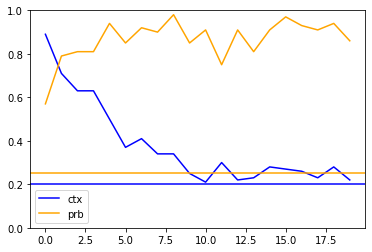

In [6]:
def plot_accuracies_old(ctx_accuracy,ctx_chance, prb_accuracy, prb_chance):
    # ctx_accuracy, ctx_chance = get_svm_accuracy(arr, lab['context'])
    # prb_accuracy, prb_chance = get_svm_accuracy(arr, lab['probe'])

    fig, ax = plt.subplots()
    _ = ax.plot(ctx_accuracy, color='blue', label='ctx')
    _ = ax.axhline(ctx_chance, color='blue')

    _ = ax.plot(prb_accuracy, color='orange', label='prb')
    _ = ax.axhline(prb_chance, color='orange')
    _ = ax.legend()
    _ = ax.set_ylim([0,1])

    return fig

def plot_accuracies(ctx_accuracy,ctx_chance, prb_accuracy, prb_chance):

    fig = go.Figure()
    t = np.linspace(0,1,len(ctx_accuracy), endpoint=False)

    # ctx line and chance
    _ = fig.add_trace(go.Scatter(x=t, y=ctx_accuracy, mode='lines',
                                 line_color='green', name='context'))
    _ = fig.add_hline(y=ctx_chance, opacity=1,
                       line=dict(color='green',
                                 dash='dot',
                                 width=1))

    # prb lline and chance
    _ = fig.add_trace(go.Scatter(x=t, y=prb_accuracy, mode='lines',
                                 line_color='black', name='probe'))

    _ = fig.add_hline(y=prb_chance, opacity=1,
                       line=dict(color='black',
                                 dash='dot',
                                 width=1))


    fig.update_layout(width=96*4, height=96*3,
                      margin={'l': 10, 'r': 10, 't': 10, 'b': 10, },
                      template='simple_white',
                      showlegend=True
                      )
    return fig


def decode_and_plot(arr):
    ufd, lbl = unfold_rep_ctx_prb(arr)
    fig = plot_accuracies_old(*get_svm_accuracy(ufd, lbl['context']), *get_svm_accuracy(ufd, lbl['probe']) )
    return fig, ufd, lbl

fig, _, _ = decode_and_plot(raster)
# img_bytes = fig.to_image(format="png", scale=1)
# Image(img_bytes)

# Principal components
contain tangled information for both context and probe
As expected prediction accuracy increases with the number of components considered,
and it's higher for the Probe than the Context identity as expected,
furthermore, the starting accuracy is higher for probe than for context, which is expected.

using 1 PCs
using 6 PCs
using 11 PCs
using 16 PCs


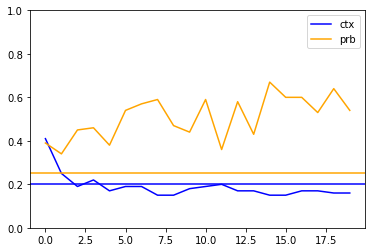

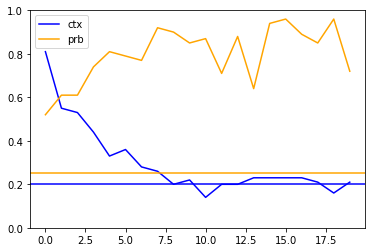

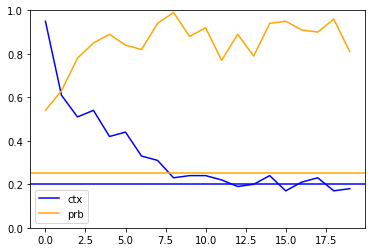

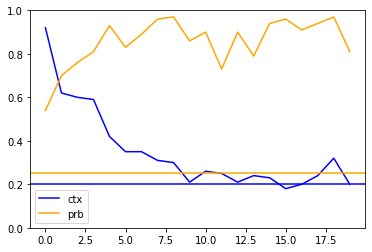

In [7]:
PC_raster = rasters['PCA'] # slice PC1, keeping dimension

n_pcs = PC_raster.shape[1]
for ii in range(1,n_pcs, 5):
    # uses a slice of up to n components
    print(f'using {ii} PCs')
    fig, _, _ = decode_and_plot(PC_raster[:,np.arange(ii),...])
    # img_bytes = fig.to_image(format="png", scale=1)
    # Image(img_bytes)

# Average out ctx and probe

This commes as an alternative of shuffling for destroying context and/or probe information.
Furthermore, by averaging out some of the variance, we can then  perform PCA over rasters
containing only context information (marginal, similar to dPCA).

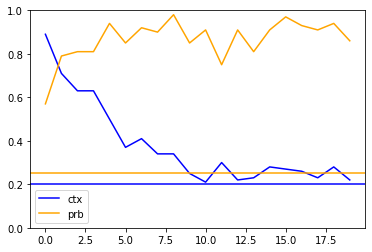

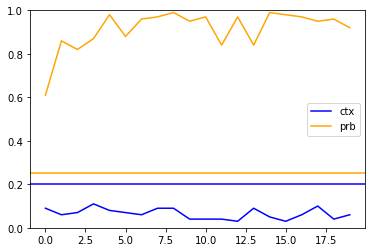

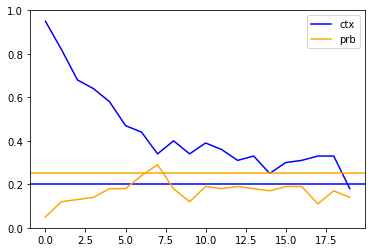

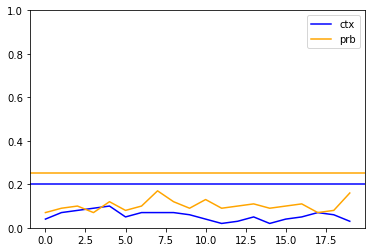

In [8]:
# destroy info by average, a dimension is lost, albeit kept as a singleton dim for broadcasting.
raster_prb = np.mean(raster, axis=2, keepdims=True) # average out context, contains only prb info
raster_ctx = np.mean(raster, axis=3, keepdims=True) # average out probe, contains only ctx info

# doese a substraction to broadcast the dimensions back to the right shape (after lossng a dim by average)
no_ctx_raster = raster - raster_ctx
no_prb_raster = raster - raster_prb
noise = raster - raster_ctx - raster_prb

fig, _, _ = decode_and_plot(raster)
fig, _, _ = decode_and_plot(no_ctx_raster)
fig, _, _ = decode_and_plot(no_prb_raster)
fig, _, _ = decode_and_plot(noise)

# Something looks fishy
hypothetically, adding together the different versions of the probe and context averaged (out) rasters, should yield
something similar to the original source raster, yet looking at the decoder performances and the total variances
this is not thew case.
This makes me think in non-orthogonality between context and probe dimensions...
shocking! (sarcasm, already observed/quantiffied with the old dPCA analysis)
this further proves the complexity of the context probe interaction and the can of worms I dont wanna open.

source raster variance:  43.02951784505011
average ctx + prb variance:  40.08028831340645
no_ctx + no_prb variance:  90.05792494855014


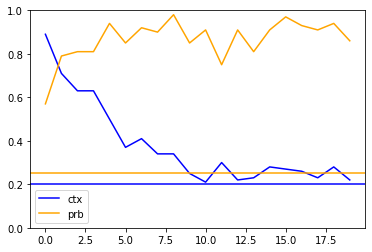

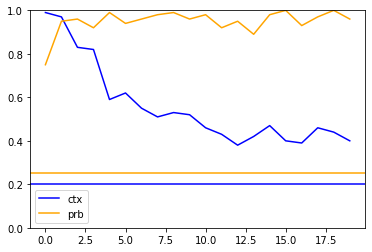

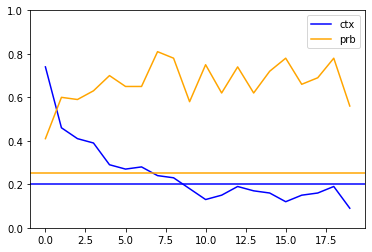

In [9]:
print('source raster variance: ', np.sum(np.var(raster, axis=(0,2,3,4))))
print('average ctx + prb variance: ', np.sum(np.var(raster_ctx+raster_prb, axis=(0,2,3,4))))
print('no_ctx + no_prb variance: ', np.sum(np.var(no_ctx_raster+no_prb_raster, axis=(0,2,3,4))))

_ = decode_and_plot(raster)
_ = decode_and_plot(raster_ctx+raster_prb)
_ = decode_and_plot(no_ctx_raster+no_prb_raster)

# Recover
now lets extract the best explaining context PCs, and sume them back to the no-context data
such that all neurons are holding the same amount of contexte information, i.e., a dense representation
1. remove probe information
2. run PCA on the raster containing context information only
3. project back n-PCs such that each PC is equally weighted across all the original neuron dimension

the tricky part lies in selecting the nature of the dense back projection.
Initially I weighted the PCs by their explained variance, i.e., artificially inflating the contribution of the most
relevant PCs, this sort of worked.
Later, by recomendation of SVD, I weighted the PCs equally, since they already contain different amounts
of variance, and capture all the variance we want to recover. This worked  much poorly.

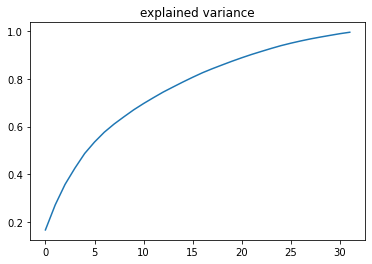

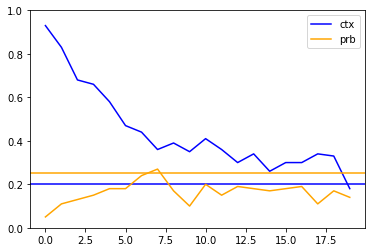

In [10]:
# fits data on trial averages, we don't want to fit noise.
def unfold_for_PCA(arr):
    rep, neu, ctx, prb, tme = arr.shape
    return np.swapaxes(arr, 0, 1).reshape([neu, -1])

def refold_from_PCA(arr, shape):
    rep, neu, ctx, prb, tme = shape
    # notice how the first two dimension are swapped during reshape
    return np.swapaxes(arr.reshape([neu, rep, ctx, prb, tme]), 0,1)

# PCA of contextual effects alone
# Remove probe information array obtained by averaging out context info
no_prb_raster = raster - raster.mean(axis=2, keepdims=True)
assert len(no_prb_raster.shape) == 5
rep, neu, ctx, prb, tme = no_prb_raster.shape

reshaped = unfold_for_PCA(no_prb_raster.mean(axis=0, keepdims=True)) # train PCA over PSTH
# reshaped = unfold_for_PCA(no_prb_raster) # train PCA over single trials

pca = PCA(n_components=32) # change this to keep all components eventually
pca.fit(reshaped.T)

# using the PCs transforms all trials
# swap axes and collapse across all dimensions but neuron, does PCA, and reshapes back to normal.
transformed = pca.transform(unfold_for_PCA(no_prb_raster).T).T
nPCs = transformed.shape[0] # automatically detected to capture n_components of variance
shape = (rep, nPCs, ctx, prb, tme)
transformed = refold_from_PCA(transformed, shape)

_ = plt.plot(np.cumsum(pca.explained_variance_ratio_))
_ = plt.title('explained variance')

_ = decode_and_plot(transformed)

#### how many principal components?
are requiered to recapitulate significant performance in the decoding accuracy??

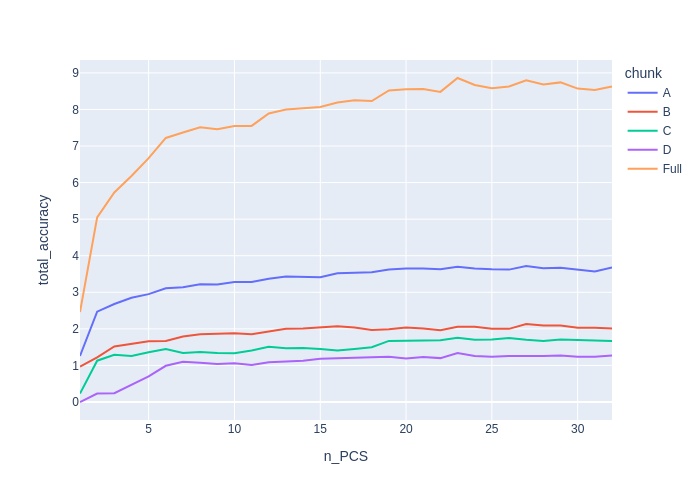

In [11]:
ufd, lbl = unfold_rep_ctx_prb(transformed)

summed_accuarcy = list()
# calculate accuracy increase as a funcion of increasing number of principal components
for pp in range(ufd.shape[1]):
    acc, chz = get_svm_accuracy(ufd[:,np.arange(pp+1),:],
                                lbl['context'])
    d = dict()
    d['n_PCS'] = pp+1
    for cnk_nm, slcr in {"A":np.s_[:5], "B":np.s_[5:10], "C":np.s_[10:15], "D":np.s_[15:], "Full":np.s_[:],}.items():
        chunk = acc[slcr]
        sum_acc = np.sum(chunk[chunk>chz])
        d[cnk_nm] = sum_acc

    summed_accuarcy.append(d)

summed_accuarcy = pd.DataFrame(summed_accuarcy)
summed_accuarcy = pd.melt(summed_accuarcy, id_vars=['n_PCS'], value_vars=['A','B','C','D','Full'],
                 var_name='chunk', value_name='total_accuracy')


# no plots the total accuracy (y) as a funciton of total PCs
fig = px.line(data_frame=summed_accuarcy, x='n_PCS', y='total_accuracy', color='chunk')
img_bytes = fig.to_image(format="png",  scale=1)
Image(img_bytes)

#### piecemeal addition
of context info in a dense way. que question is how to weight the principal components, albeit for a given PC,
it will be equally weighted for all neurons

(32, 33)


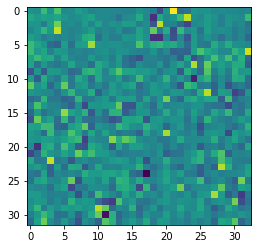

In [12]:
# the PCA components are showing us the weight of each componetn (y) used to recreate each neuron (x)
comps = pca.components_
print(comps.shape)
plt.imshow(comps)
# idealy we want each component to be equally weighted across all neurons (horizontal lines).
# however different components should have overall different weights to preserve variance

original summed var across neurons 4.878957093475751
summed var across principal components 4.868332529501108
dense_weigths shape (32, 33)
dense_weights var explained 1.0


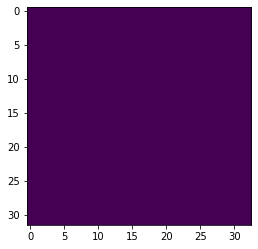

In [13]:
target_var = np.sum(np.var(reshaped, axis=1))
print('original summed var across neurons', target_var)
print('summed var across principal components', np.sum(pca.explained_variance_))

n_cells = no_ctx_raster.shape[1]

# dense_weights = np.tile(pca.explained_variance_[:,np.newaxis], [1,n_cells]) # MLE: PCs weighted by eigenvalue
dense_weights = np.ones(comps.shape)/np.sqrt(comps.shape[1]) # SVD: all PCS equally weighted

print('dense_weigths shape', dense_weights.shape)
print('dense_weights var explained', np.sqrt(np.sum((dense_weights[0,:])**2)))# root mean sum should be == 1
plt.imshow(dense_weights)

dense variance 4.856161698177356
dense variance corrected 4.878957093475748


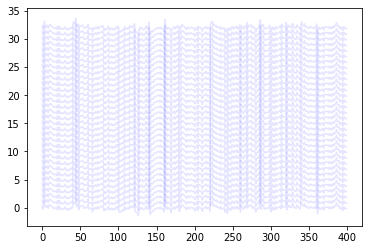

In [14]:
# now lets transform the principal components back into dense cells
trans = pca.transform(reshaped.T)
dense = (trans @ dense_weights).T

print('dense variance',np.sum(np.var(dense, axis=1)))

# all output cells are equal and have equal variance, To adjust it we jut need to find
# a scalar to equally scale all output vectors

v_var = np.var(dense, axis=1)[0] # variance per component
scaler = np.sqrt(target_var / dense.shape[0]) / np.sqrt(v_var)

print('dense variance corrected',np.sum(np.var(dense*scaler, axis=1)))
# _ = plt.plot(dense.T, color='gray', alpha=0.1)
_ = plt.plot(dense.T*scaler + np.arange(33)[None,:], color='blue', alpha=0.1)

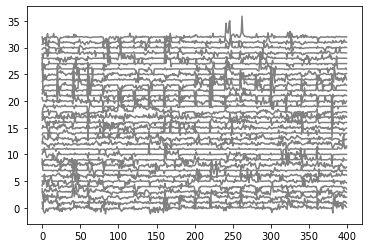

In [15]:
_ = plt.plot(reshaped.T + np.arange(33)[None,:], color='gray', alpha=1)

In [16]:
# now lets transform the principal components back into dense cells\
resh = unfold_for_PCA(no_prb_raster) # 5d -> 2d
trans = pca.transform(resh.T)
dense = (trans @ dense_weights).T
print('dense variance',np.sum(np.var(dense, axis=1)))

# all output cells are equal and have equal variance, To adjust it we jut need to find
# a scalar to equally scale all output vectors
target_var = np.sum(np.var(resh, axis=1))
print("target variance ", target_var)
v_var = np.var(dense, axis=1)[0] # variance per component
scaler = np.sqrt(target_var / dense.shape[0]) / np.sqrt(v_var)

print('dense variance corrected',np.sum(np.var(dense*scaler, axis=1)))
# _ = plt.plot(dense.T, color='gray', alpha=0.1)
# _ = plt.plot(dense.T*scaler, color='blue', alpha=0.1)

dense variance 24.45892050242785
target variance  24.346811929542977
dense variance corrected 24.34681192954293


24.34681192954298
24.45892050242785


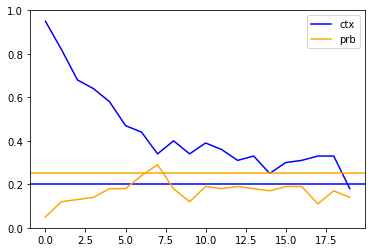

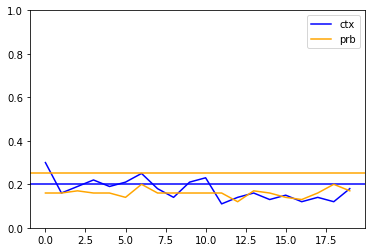

In [17]:
# refold the dense transofmration
dense_folded = refold_from_PCA(dense, no_prb_raster.shape)

print(np.sum(np.var(no_prb_raster, axis=(0,2,3,4))))
print(np.sum(np.var(dense_folded, axis=(0,2,3,4))))

_ = decode_and_plot(no_prb_raster)
_ = decode_and_plot(dense_folded)

43.02951784505011
90.05792494855014
59.02358264196709


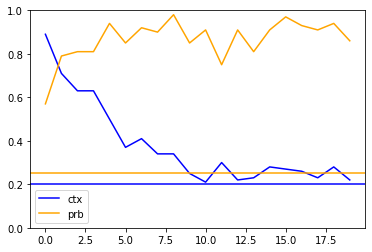

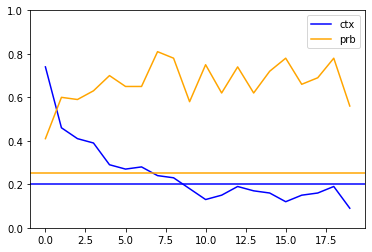

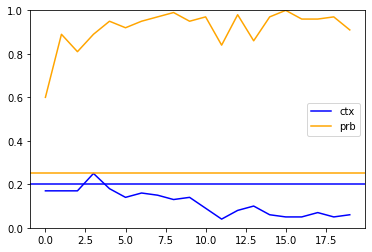

In [18]:
reconstituted = no_prb_raster + no_ctx_raster
dense_raster = no_ctx_raster + dense_folded # dense context


print(np.sum(np.var(raster, axis=(0,2,3,4))))
print(np.sum(np.var(reconstituted, axis=(0,2,3,4))))
print(np.sum(np.var(dense_raster, axis=(0,2,3,4))))

_ = decode_and_plot(raster)
_ = decode_and_plot(reconstituted)
_ = decode_and_plot(dense_raster)

#### something is off
I must have missed something, and variances are not consistent. albeit the densification of the context seems
to be hindering decoding, as expected!!
Having consisten variances will be needed to give more strength to this densification procedure.-

# context effect quantification

now lets to a really simple quantification of the context pairwise differences, akin to the context mass
analysis, but simpliffied and deterministic i.e. more similar to the approach used with the deterministic
model predictions.

lots of this code is inspired and/or copied over from the model analysis pipeline:
src/models/param_tools.py get_pre_err
220412_resp_vs_pred_metrics.py

In [19]:
def  calc_ctx_effects(arr, cellids, fs):
    # replace context by context-pair derived difference
    rep, chn, ctx, prb, tme = arr.shape
    ctx_pairs = list(itt.combinations(range(ctx), 2))

    diff_arr = np.empty([rep, chn, len(ctx_pairs), prb, tme])

    for cpidx, (c0, c1) in enumerate(ctx_pairs):
        diff_arr[:, :, cpidx, :, :] = arr[:, :, c0, :, :] - arr[:, :, c1, :, :]

    diff_arr = np.mean(diff_arr, axis=0) # trial average, drop dim for backwards compatibility

    # literal contexts and probe for dimlabdict
    contexts = list(range(0, prb + 1))
    probes = list(range(1, prb + 1))

    # define time stamps for the whole probe predictionn
    fs = raster_meta['raster_fs']

    time = np.linspace(0, tme / fs, tme, endpoint=False)

    assert fs == 20 #
    time_chunks = {'A': np.s_[..., :5], 'B': np.s_[..., 5:10],
                   'C': np.s_[..., 10:15], 'D': np.s_[..., 15:],
                   'Full': np.s_[..., :]}

    IDF = list()

    for chunk_name, slicer in time_chunks.items():
        diff_arr_chunk = diff_arr[slicer]

        ##### first simple integtral over the difference #####
        # creates label dictionalry
        dim_labl_dict = {'id': cellids,
                         'context_pair': [f'{c1:02d}_{c2:02d}' for c1, c2 in itt.combinations(contexts, 2)],
                         'probe': probes,
                         'time': time[slicer[-1]]}  # todo, ensure to shift time depending on big bin

        # with empty mask, i.e. no mask for internal compatibility
        masked_arr = np.ma.array(diff_arr_chunk, mask=np.full_like(diff_arr_chunk, False))
        idf = metrics_to_DF(masked_arr, dim_labl_dict, metrics=['integral']) # todo, drop absolute integral, keep just difference with sign.

        idf['stim_count'] = len(probes)
        idf['chunk'] = chunk_name
        IDF.append(idf)

    return pd.concat(IDF, ignore_index=True, axis=0)

cellids = channels['SC']
sparse_DF = calc_ctx_effects(raster, cellids, raster_meta['raster_fs'])
dense_DF = calc_ctx_effects(dense_raster, cellids, raster_meta['raster_fs'])

# Raw visualization

show fingerprints of context modulation space for multiple neurons in a site

In [20]:
def plot_cell_coverage(IDF, cellid):
    z = IDF.query(f"id == '{cellid}'"
                  ).pivot(index='context_pair', columns='probe', values='value'
                          ).values
    # z[z == 0] = np.nan
    heatmap = go.Figure(go.Heatmap(z=z, coloraxis='coloraxis', connectgaps=False))
    try:
        thismax = np.nanmax(z)
    except:
        thismax = 0

    return heatmap, thismax


def plot_site_coverages(IDF, cells_toplot):
    # defines the squarest area to efficiently encompass the desired number of subplots
    rows = int(np.floor(np.sqrt(len(cells_toplot))))
    cols = int(np.ceil(np.sqrt(len(cells_toplot))))
    if rows * cols < len(cells_toplot):
        cols += 1

    max_vals = list()
    fig = make_subplots(rows=rows, cols=cols,
                        shared_xaxes='all', shared_yaxes='all',
                        horizontal_spacing=0.01, vertical_spacing=0.05,
                        subplot_titles=cells_toplot,
                        )

    # individual neuron examples
    for cc, cell_eg in enumerate(cells_toplot):
        hmap, maxval = plot_cell_coverage(IDF, cell_eg)
        max_vals.append(maxval)
        row, col = int(np.floor(cc / cols)) + 1, (cc % cols) + 1
        hmap = hmap['data']
        fig.add_traces(hmap, rows=[row] * len(hmap), cols=[col] * len(hmap))

    ##### formating #######
    # reduces size of subplot titles
    fig.update_annotations(font_size=10)

    # ensures spines, and no ticks or tick labels
    fig.update_xaxes(scaleanchor='y',
                     constrain='domain',
                     showticklabels=False,
                     ticks='',
                     showline=True,
                     mirror=True,
                     )

    fig.update_yaxes(constrain='domain',
                     showticklabels=False,
                     ticks='',
                     showline=True,
                     mirror=True,
                     )

    # labels on top left panel
    df = IDF.query(f"id == '{cells_toplot[0]}'").pivot(index='context_pair', columns='probe', values='value')
    ctx_prs = [f"{int(pp.split('_')[0])}_{int(pp.split('_')[1])}"
               for pp in df.index.to_list()]
    prbs = df.columns.tolist()

    # probes, x axis
    fig.update_xaxes(title=dict(text='probe',
                                standoff=0,
                                font_size=10), showticklabels=True,
                     tickmode='array',
                     tickvals=list(range(len(prbs))),
                     ticktext=prbs,
                     tickfont_size=9,
                     col=1, row=1)
    # context pairs, y axis
    fig.update_yaxes(title=dict(text='context_pair',
                                standoff=0,
                                font_size=10), showticklabels=True,
                     tickmode='array',
                     tickvals=list(range(len(ctx_prs))),
                     ticktext=ctx_prs,
                     tickangle=0,
                     tickfont_size=9,
                     col=1, row=1)

    w, h = 4 * 96, 4.5 * 96
    fig.update_layout(template="simple_white",
                      width=w, height=h,
                      margin=dict(l=10, r=10, t=30, b=10),
                      coloraxis=dict(showscale=True,
                                     colorscale='inferno',
                                     colorbar=dict(
                                         orientation='v',
                                         thicknessmode='fraction',
                                         thickness=0.02,
                                         lenmode='fraction',
                                         len=1,
                                         title=dict(text='Amplitude (delta Z-Score)',
                                                    side='right',
                                                    font_size=10),
                                         tickangle=-50,
                                         tickfont_size=9,
                                     ),
                                     ),
                      )

    return fig

/home/mateo/miniconda3/envs/context_probe_analysis/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



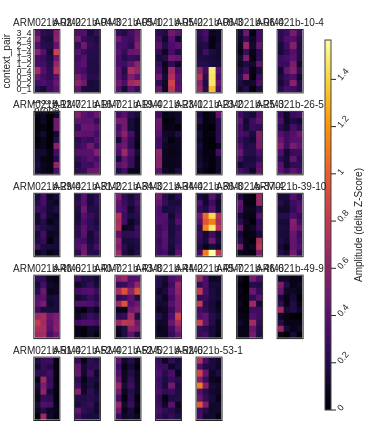

In [21]:
fig = plot_site_coverages(sparse_DF.query("chunk == 'Full' "), cellids[:])
img_bytes = fig.to_image(format="png")
Image(img_bytes)

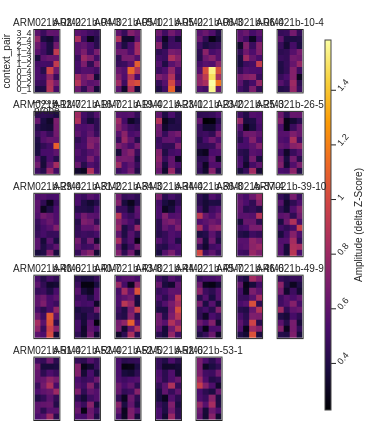

In [22]:
fig = plot_site_coverages(dense_DF.query("chunk == 'Full' "), cellids[:])
img_bytes = fig.to_image(format="png")
Image(img_bytes)

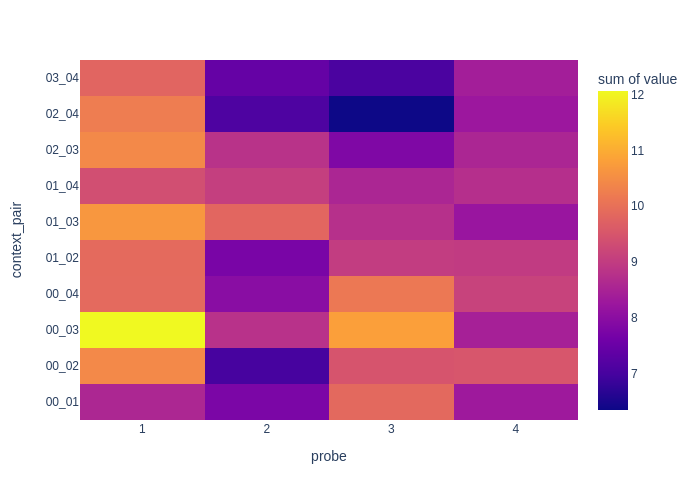

In [23]:
fig = px.density_heatmap(sparse_DF.query("chunk == 'Full' "),x='probe', y='context_pair', z='value', histfunc='sum')
img_bytes = fig.to_image(format="png")
Image(img_bytes)

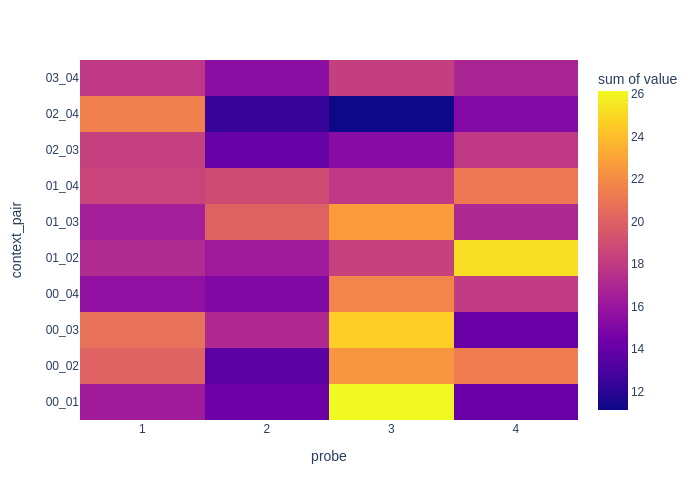

In [24]:
fig = px.density_heatmap(dense_DF.query("chunk == 'Full' "),x='probe', y='context_pair', z='value', histfunc='sum')
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [25]:
print(sparse_DF.query("chunk == 'Full' ")['value'].sum())
print(dense_DF.query("chunk == 'Full' ")['value'].sum())

357.00414056134804
718.9328831449546


# Geometrical interpretation

In light of the previous failure with PC projections, I atempted to go back into a more "manual" densification
process.

Thinking about it, dense means that all neurons are contributing equally to the pairwise differences
seen between instances.

From a geometric perspective this means that the dx == dy for a system of 2 neuron x and y, where d is the
delta between contexts. This forms an isosceles triangle where the cathetus are defined by the Manhattan distance,
and the hypotenuse is defined by the euclidean distance.

In summary, a "densification" process is characterized by an isocelization, where the L1 (manhattan) is mantained
and the L2 (euclidean) is minimized.

In [26]:
def plot_distances(V1, V2):
    x1 = V1[0]
    y1 = V1[1]
    x2 = V2[0]
    y2 = v2[1]

    L1 = np.linalg.norm(V1-V2, ord=1)
    L2 = np.linalg.norm(V1-V2, ord=2)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[x1,x2], y=[y1,y2], mode='markers', marker_color='black', name='instances'))
    fig.add_trace(go.Scatter(x=[x1,x1,x2], y=[y1,y2,y2], mode='lines', line_color='gray', line_dash='dot',
                             name='Manhattan distance'))
    fig.add_trace(go.Scatter(x=[x1,x2], y=[y1,y2], mode='lines', line_color='pink', line_dash='dot',
                             name='Euclidean distance'))

    # distances, L1 and L2
    fig.add_trace(go.Scatter(x=[x1-L1,x1, x1+L1, x1, x1-L1],
                             y=[y1, y1+L1, y1, y1-L1, y1],
                             mode='lines', line_color='black', line_dash='dot',
                             showlegend=False))

    fig.add_shape(type="circle", xref="x", yref="y",
                  x0=x1-L2, y0=y1-L2, x1=x1+L2, y1=y1+L2,
                  line_color="red", line_dash='dot')

    fig.update_xaxes(constrain='domain', range=[0,5], title_text='neuron 2 activity (AU)')
    fig.update_yaxes(scaleanchor='x', scaleratio=1, constrain='domain', range=[0,5],
                     title_text='neuron 1 activity (AU)')
    fig.add_vline(0)
    fig.add_hline(0)

    return fig

sparse L1:  2.23606797749979
sparse L2:  3.0


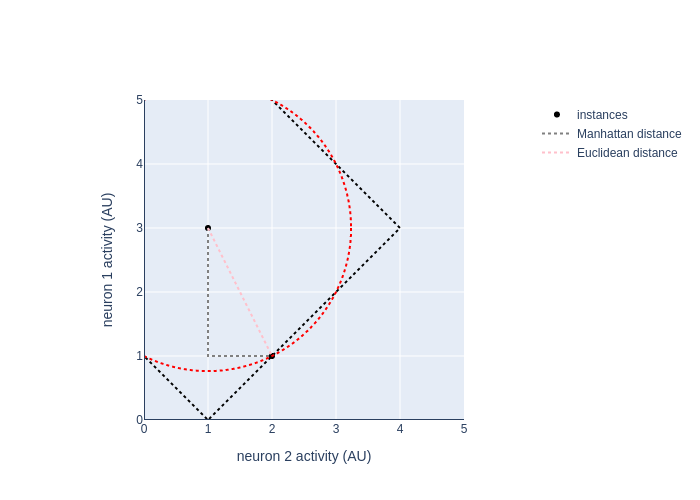

In [27]:
# eg original vectors
v1 = np.asarray([1,3])
v2 = np.asarray([2,1])

print('sparse L1: ', np.linalg.norm(v1-v2, ord=2))
print('sparse L2: ', np.linalg.norm(v1-v2, ord=1))

fig = plot_distances(v1, v2)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

dense L1:  2.1213203435596424
dense L2:  3.0


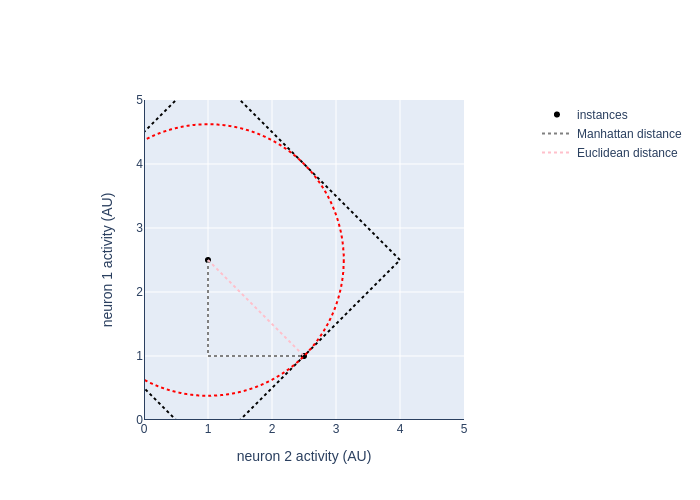

In [28]:
# densiffiend vectors
d1 = np.asarray([1,2.5,0])
d2 = np.asarray([2.5,1,0])
print('dense L1: ', np.linalg.norm(d1-d2, ord=2))
print('dense L2: ', np.linalg.norm(d1-d2, ord=1))

fig = plot_distances(d1, d2)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

## Keep L1, minimize L2

its is clear that the way of reaching an isosceles triangle is to mantain the L1 distance (total neuronal activity),
while minimizing the L2 distance. This has strong implications!, as the L2 is reduces, so is the discriminability of
clounds of points around a centroid, in other words, the densification of neuronal responses leads to a less clear and
different representation of contexts.

Lets automitize this by defining a transformation of our points in state space and a loss function
such that we can tweak the transformation while minimizing loss.

the transformation is simply the motion of point in 2d coordinates ie. addign different xy offsets to every point

the loss function is a little bit more involved: keeping all the pairwise L1 norms, while minimizing all L2 norms.
this effectively forces points to form isoceles triangles between points


In [29]:
def densify(offsets, vctrs):
    """stacked list of 2(n) dimensional vectors"""
    assert offsets.size == vctrs.size

    # calculate pairwise L1 from original values that we must preserve
    L1o = pdist(vctrs, metric='cityblock') / vctrs.shape[1]

    moved = np.reshape(vctrs.flatten() + offsets.flatten(), vctrs.shape)

    # loss is a combination of preserving L1 and reducing L2 and remaining close to the original position
    L1 = pdist(moved, metric='cityblock') / vctrs.shape[1]
    L2 = pdist(moved, metric='euclidean')
    shift = np.linalg.norm(offsets.reshape(vctrs.shape), ord=2, axis=1)

    loss = np.sum(L2) + np.sum((L1-L1o)**2) + np.sum(shift) * 0.01
    return  loss

# test
vctrs = np.asarray([[1,3],
                    [2,1]])
print(pdist(vctrs))
print(densify(np.zeros_like(vctrs), vctrs))

[2.23606798]
2.23606797749979


In [30]:
vctrs = np.asarray([[1,3],
                    [2,1],
                    [4,2],
                    [5,7],
                    [7,5]
                    ])

progress = list()
progress_val = list()
def cb(x):
    transformed = vctrs + x.reshape(vctrs.shape)
    progress.append(transformed)
    progress_val.append(densify(x, vctrs))

res = minimize(densify, np.zeros_like(vctrs), method='nelder-mead',
               args=vctrs, options={'xatol': 1e-8, 'disp': False}, callback=cb)

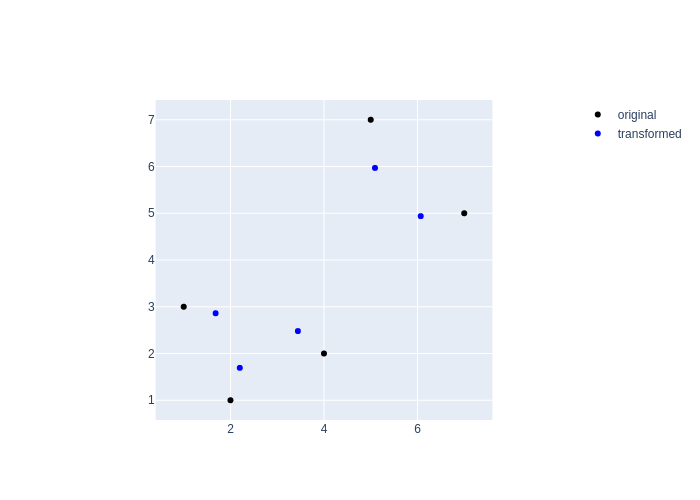

In [31]:
transformed = vctrs + res.x.reshape(vctrs.shape)

np.diff(transformed, axis=0)
fig = go.Figure()
_ = fig.add_trace(go.Scatter(x=vctrs[:,0], y=vctrs[:,1],
                             mode='markers', marker_color='black', name='original'))
_ = fig.add_trace(go.Scatter(x=transformed[:,0], y=transformed[:,1],
                             mode='markers', marker_color='blue', name='transformed'))
fig.update_xaxes(constrain='domain')
fig.update_yaxes(scaleanchor='x', scaleratio=1, constrain='domain')
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [32]:
# this is a short animation showing the evolution of the points as the transformation is optimizede.
# for some reasone plotly is failing to display things
plot_progress = False

if plot_progress:
    # transforms the list of positions into a x,y wide, time-long dataframe for plotly animation
    timeDF = list()
    # just save 5 second video at fps
    dur = 5
    fps = 30
    for ii in range(0, len(progress), int(len(progress)/(dur*fps))):
        poss = progress[ii]
        data = np.concatenate([poss, np.arange(poss.shape[0])[:,None]], axis=1)
        df = pd.DataFrame(data=data, columns=['x', 'y', 'vctr'])
        df['iter'] = ii
        timeDF.append(df)

    timeDF = pd.concat(timeDF)

    fig = px.scatter(timeDF, x="x", y="y", animation_frame="iter", animation_group='vctr')

    # constrain the whole animation to 5 seconds
    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = (1/fps)*1000*0.7
    fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = (1/fps)*1000*0.3
    fig.update_xaxes(constrain='domain')
    fig.update_yaxes(scaleanchor='x', scaleratio=1, constrain='domain')
    fig.show()

# context effect diagonalization
1. remove trial average probe effects, this should center the contexts around the mean
2. measure the trial average context effects Manhattan distance from the origin
3. move the context effects towards the equality diagonal i.e. all neurons are equally active, ensuring Manhattan distance is retained
4. add back in the probe effects
5. keep track of the transformations of the original data and apply to single trial matrices
5. measure the pairwise contextual effects

the rational here is that by diagonalizing the context effects, we aredensifying them, i.e.
all neuron are contributing the same firing rate. furthermore, if we consider pairwise comparisons between contexts
since they are on the same diagonal, their euclidena distance and their manhattan distances are forming an isoceles
triangle, which is asociated with dense representations.

In [33]:

def get_diagonalizations(fnArr):
    psth = fnArr.mean(axis=0, keepdims=True)
    prb_psth = psth.mean(axis=2, keepdims=True) # average out contexts -> probe centroids
    no_prb_psth = psth - prb_psth
    rep, chn, ctx, prb, tme = no_prb_psth.shape

    # despite having averaged out the probes, since there is an interaction between probe and context
    # we need to keep this into account (?), therefore we have to do a probewise "diagonalization"

    no_prb_diag = np.empty(psth.shape) # parital diagonalization for no-probe data
    full_diag = np.tile(-prb_psth.copy(),[1,1,ctx,1,1]) # full diagonalization for full data (ctx and prb present)

    for pp, tt in np.ndindex(prb, tme):
        # print(pp, tt)
        arr = no_prb_psth[...,pp,tt]

        # calculate the L1s to preserve
        L1 = np.linalg.norm(arr,ord=1,axis=1, keepdims=True) # shape 1rep x 1chn x Nctx x

        # since L1 is signless, there are two points in the diagonal for each L1, we want to move points to
        # the closets point. find which points are mostly possitive or negative neurons and define the
        # "signed" diagonal target
        sign_flip = np.sign(arr.sum(axis=1, keepdims=True))
        sign_flip[sign_flip == 0] = 1 # in the very improbable case of balanced activity, send to the possitive diagonal

        # all neurons contribute equally (division),
        # how much do we need to give or take from each neuron to reach this equal contribution?? (subtraction)
        toadd = (L1 * sign_flip / chn) - arr

        no_prb_diag[:,:,:,pp,tt] = toadd
        full_diag[:,:,:,pp,tt] += toadd

    return full_diag, no_prb_diag

test_raster = raster[:,np.asarray([19,21]),...][...,0,0][:,:,:,None,None] # 2 neurons, 1 probe, 1 time point
full_diag, no_prb_diag = get_diagonalizations(test_raster)

In [34]:
raster

array([[[[[-0.54347321,  2.82269844,  4.50578427, ...,  2.82269844,
            1.13961262, -0.54347321],
          [ 1.13961262,  1.13961262, -0.54347321, ...,  1.13961262,
           -0.54347321, -0.54347321],
          [ 1.13961262,  1.13961262,  1.13961262, ...,  1.13961262,
            1.13961262,  1.13961262],
          [ 1.13961262,  2.82269844, -0.54347321, ...,  1.13961262,
            4.50578427,  1.13961262]],

         [[-0.54347321,  2.82269844,  2.82269844, ...,  1.13961262,
           -0.54347321,  1.13961262],
          [ 1.13961262, -0.54347321, -0.54347321, ...,  1.13961262,
           -0.54347321,  1.13961262],
          [ 1.13961262,  1.13961262, -0.54347321, ..., -0.54347321,
            1.13961262, -0.54347321],
          [-0.54347321,  1.13961262, -0.54347321, ...,  2.82269844,
            2.82269844,  1.13961262]],

         [[ 1.13961262,  4.50578427,  1.13961262, ...,  1.13961262,
            1.13961262,  1.13961262],
          [-0.54347321, -0.54347321, -0.54

In [35]:
# check that thigs look diagonal
def plot_eg_diag(inPSHT, inDiag):
    fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
    for cc in range(ctx):
        _ = axes[0].scatter(inPSHT[0,0,cc,0,0], inPSHT[0,1,cc,0,0])
        _ = axes[1].scatter((inPSHT+inDiag)[0,0,cc,0,0], (inPSHT+inDiag)[0,1,cc,0,0])

    # the mean has moved preserved
    _ = axes[0].scatter(*inPSHT.mean(axis=2).squeeze(), color='black', marker="X", s=100)
    _ = axes[1].scatter(*(inPSHT+inDiag).mean(axis=2).squeeze(), color='black', marker="X", s=100)

    # the absolute sum of the neurons (L1) is preserved
    print("OG L1: ", np.absolute(inPSHT).sum(axis=1).squeeze())
    print("diagonal L1: ", np.absolute(inPSHT+inDiag).sum(axis=1).squeeze())


    axes[1].plot(axes[1].get_xlim(),axes[1].get_xlim(), color='black')

    for ax in axes:
        _ = ax.axvline(0, color='black')
        _ = ax.axhline(0, color='black')

    return fig

OG L1:  [8.24041821 1.26341762 5.72363857 2.52180744 3.44898407]
diagonal L1:  [8.24041821 1.26341762 5.72363857 2.52180744 3.44898407]


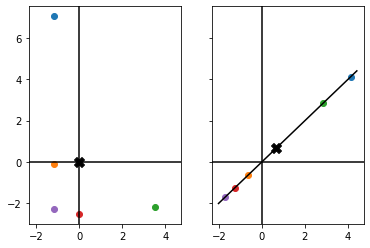

In [36]:
# diagonalization of data with no probe info
psth = test_raster.mean(axis=0, keepdims=True)
prb_psth = psth.mean(axis=2, keepdims=True) # average out contexts -> probe centroids
no_prb_psth = psth - prb_psth

fig = plot_eg_diag(no_prb_psth, no_prb_diag)

OG L1:  [9.61511315 2.46999207 4.86596498 1.14711249 0.28442562]
diagonal L1:  [8.24041821 1.26341762 5.72363857 2.52180744 3.44898407]


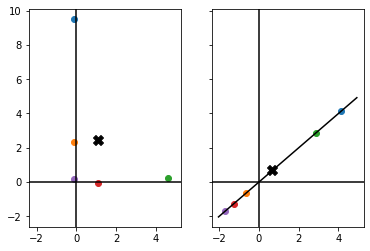

In [37]:
# diagonalization of full data without recovering probe effect
fig = plot_eg_diag(psth, full_diag)

OG L1:  [9.61511315 2.46999207 4.86596498 1.14711249 0.28442562]
diagonal L1:  [11.75387752  2.25004169  9.23709788  1.37469495  1.37469495]


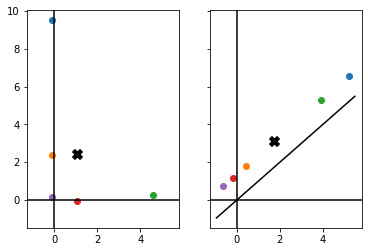

In [38]:
# diagonalization of full data recovering probe information
fig = plot_eg_diag(psth, no_prb_diag)

# full run
using all neurons and all time points. then calculate the pairwise contextual effects and plot

/home/mateo/miniconda3/envs/context_probe_analysis/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



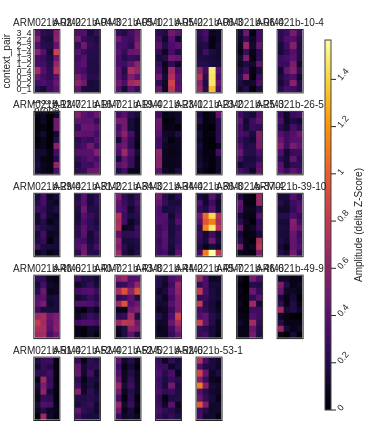

In [39]:
fig = plot_site_coverages(sparse_DF.query("chunk == 'Full' "), cellids[:])
img_bytes = fig.to_image(format="png")
Image(img_bytes)

/home/mateo/miniconda3/envs/context_probe_analysis/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



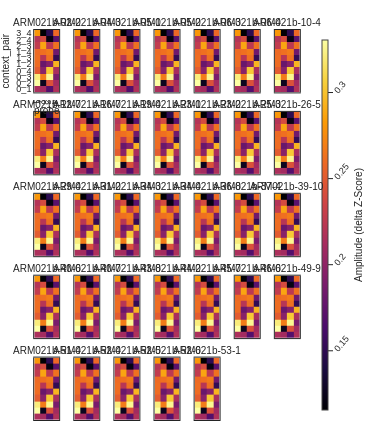

In [40]:
full_diag, no_prb_diag = get_diagonalizations(raster)
diag_DF = calc_ctx_effects(raster+no_prb_diag, cellids, raster_meta['raster_fs'])

fig = plot_site_coverages(diag_DF.query("chunk == 'Full' "), cellids[:])
img_bytes = fig.to_image(format="png")
Image(img_bytes)

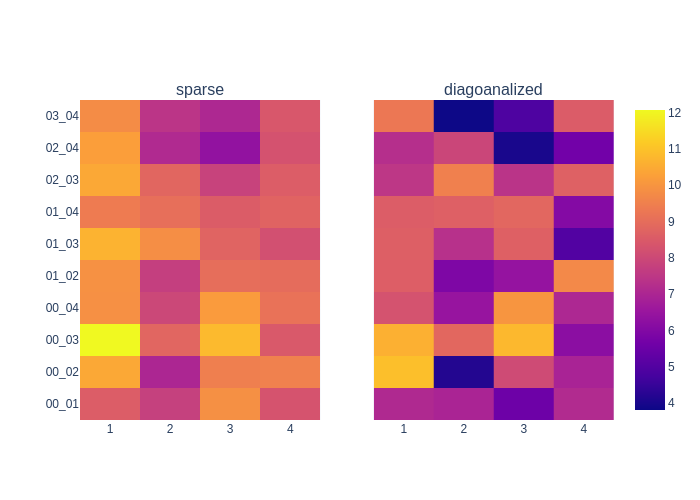

In [41]:
fig = make_subplots(1,2, subplot_titles=['sparse', 'diagoanalized'])



_ = fig.add_trace(
    px.density_heatmap(sparse_DF.query("chunk == 'Full' "),
                       x='probe', y='context_pair', z='value',
                       histfunc='sum')['data'][0],
    row=1, col=1
)

_ = fig.add_trace(
    px.density_heatmap(diag_DF.query("chunk == 'Full' "),
                       x='probe', y='context_pair', z='value',
                       histfunc='sum')['data'][0],
    row=1, col=2
)

img_bytes = fig.to_image(format="png")
Image(img_bytes)

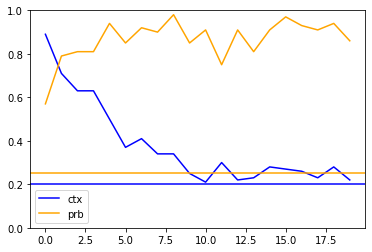

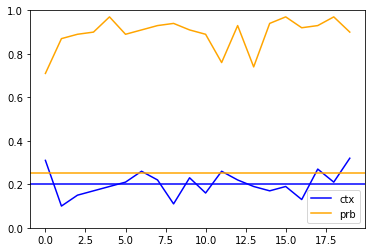

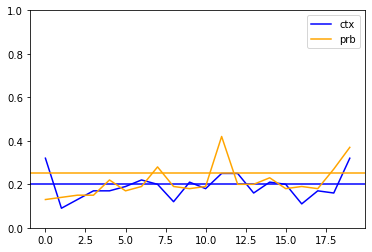

In [42]:
fig, _, _ = decode_and_plot(raster)
fig, _, _ = decode_and_plot(raster+no_prb_diag)
fig, _, _ = decode_and_plot(raster+full_diag)

# now try to get all sites
old and broken

In [43]:
# quick cache
acc_df_file = pl.Path(config['paths']['analysis_cache']) / f'221219_SC_decoder_accuracies'

recache_acc = False

if acc_df_file.exists():
    print('cache found, reloading')
    accuracy_df = jl.load(acc_df_file)

elif (not acc_df_file.exists()) or recache_acc:
    accuracy_df = list()
    for site in good_sites:

        fn = tensor_loaders['SC']
        if fn.check_call_in_cache(site, **raster_meta):
            print(f'cache found for {site}')
            raster, _ = fn(site, **raster_meta)
            print(f'####\n'
                  f'raster shape {raster.shape}'
                  )
        else:
            print(f"cant load {fn} with {raster_meta}.\n this should be cached, why is it failing? ")

        unfolded, labels = unfold_rep_ctx_prb(raster)

        for part in ['context', 'probe']:
            accuracy, chance = get_svm_accuracy(unfolded, labels[part])

            d = {'site': site,
                 'part': part,
                 'accuracy': accuracy,
                 'chance': chance}

            accuracy_df.append(d)

    accuracy_df = pd.DataFrame(accuracy_df)

    jl.dump(accuracy_df, acc_df_file)

cache found, reloading


In [44]:
accuracy_df.groupby('chance').agg('count')

,site,part,accuracy
chance,,,
0.100000,28,28,28
0.111111,1,1,1
0.250000,35,35,35


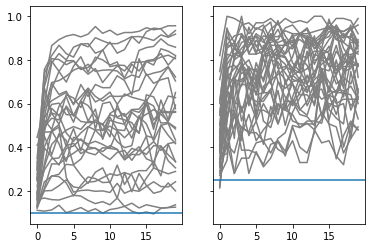

In [45]:
fig, axes = plt.subplots(1, 2, squeeze=True, sharey=True, sharex=True)

for cc, chance in enumerate([0.1, 0.25]):
    ax = axes[cc]
    arr = np.stack(accuracy_df.query(f"chance == {chance}").loc[:, 'accuracy'].values)
    _ = ax.plot(arr.T, color='gray')
    _ = ax.axhline(chance)